# Using vireo for multiplexing, followed by lineage tracing of those groups

# 1. Change to analysis directory

In [1]:
import os
os.chdir("/data2/mito_lineage")#/Analysis/multiplex")

In [2]:
pwd

'/data2/mito_lineage'

### Remove this when running in snakemake

## 1.1 Parameters

In [3]:
# INDIR= "data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn"
# OUTDIR= "data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex"
# N_DONORS=5
# sample_names="" 
# to_elbo = False

INDIR="output/clones/CHIP_april08_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn"
OUTDIR="output/clones/CHIP_april08_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex"
N_DONORS=5
sample_names="Control,Flt3l,Input"
to_elbo=False

In [4]:
# # Parameters
# INDIR="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/"
# #INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/"
# N_DONORS=5
# OUTDIR=""#"data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/flt3"
# #sample_csv="/data2/mito_lineage/parameters/CHIP_april08_2021/CHIP_april08_2021.csv"
# sample_names="" #"Control,Flt3l,Input"

## 1.2 Import packages

In [5]:
from os.path import join, exists, dirname
from glob import glob
import mplh.cluster_help as ch
import os
from vireoSNP.plot.base_plot import heat_matrix
from vireoSNP import Vireo
import src.pseudo_batch as pb
import vireoSNP
print(vireoSNP.__version__)
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.vireo.vireo_utils import run_vireo, plot_vireo_out, extract_clusters, run_elbo, separate_donors
%load_ext autoreload
%autoreload 2

0.5.6


In [6]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

## 1.3 Load

In [7]:
AD_F = join(INDIR, "cellSNP.tag.AD.mtx")
DP_F = join(INDIR, "cellSNP.tag.DP.mtx")
cell_inds_names = join(INDIR,"cell_indices_*.txt")
cells_meta_f = join(INDIR, "cells_meta.tsv")
vars_f = join(INDIR, "cellSNP.base.vcf")


In [8]:
vars_df = pd.read_csv(vars_f, sep="\t")
vars_df

,index_x,#CHROM,POS,REF,ALT,strand_correlation_x,vmr_x,n_cells_over_5_x,n_cells_over_20_x,old output/clones/CHIP_april08_2021/MTblacklist/Control/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,...,n_cells_over_5_y,n_cells_over_20_y,old output/clones/CHIP_april08_2021/MTblacklist/Flt3l/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,index,strand_correlation,vmr,n_cells_over_5,n_cells_over_20,old output/clones/CHIP_april08_2021/MTblacklist/Input/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,new ID
0,62G>C,chrM,62,62G,C,1.000000,0.023067,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,73A>G,chrM,73,73A,G,0.997152,0.327625,329.0,329.0,2.0,...,2823.0,2751.0,3.0,73A>G,0.996919,0.382955,119.0,116.0,1.0,2
2,150C>T,chrM,150,150C,T,0.977417,0.624277,177.0,177.0,3.0,...,727.0,676.0,10.0,150C>T,0.979327,0.670372,61.0,49.0,3.0,3
3,195T>C,chrM,195,195T,C,0.986475,1.003792,22.0,22.0,4.0,...,1125.0,1047.0,11.0,195T>C,0.990257,0.623396,44.0,31.0,4.0,4
4,248A>G,chrM,248,248A,G,0.768094,4.211685,95.0,88.0,5.0,...,247.0,227.0,13.0,248A>G,0.705534,4.216593,24.0,14.0,5.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,NaN,chrM,15596,15596G,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15596G>C,1.000000,0.021713,0.0,0.0,173.0,497
497,NaN,chrM,15784,15784T,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15784T>C,0.999269,0.358081,1.0,1.0,176.0,498
498,NaN,chrM,16433,16433A,T,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16433A>T,0.997595,0.011517,0.0,0.0,193.0,499
499,NaN,chrM,16465,16465C,T,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16465C>T,0.998655,0.101256,1.0,0.0,194.0,500


In [9]:
# columns are 'ID', 'raw ID', and 'new index'. The first contains the
# suffix with the old id, the new index contains the mapping to the
# outputted subsampled cells, which is 1-based, and the raw ID is the initial cell IDs without the suffix.   
cells_meta = pd.read_csv(cells_meta_f, sep="\t")
cells_meta = cells_meta.sort_values('new index')
print('cells_meta', cells_meta.head())
sample_names = {ind:val for ind,val in enumerate(sample_names.split(","))}
print('sample_names', sample_names)

cells_meta                            ID              raw ID  new index condition
0  AAACTGCTCTCGCGGA-1_Control  AAACTGCTCTCGCGGA-1          1   Control
1  AAAGATGCAGCAACGA-1_Control  AAAGATGCAGCAACGA-1          2   Control
2  AAAGGATGTGCTGTGC-1_Control  AAAGGATGTGCTGTGC-1          3   Control
3  AAAGGATTCAAAGTAG-1_Control  AAAGGATTCAAAGTAG-1          4   Control
4  AAATGCCCAGAAAGAG-1_Control  AAATGCCCAGAAAGAG-1          5   Control
sample_names {0: 'Control', 1: 'Flt3l', 2: 'Input'}


In [10]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()
AD_shape = AD.todense().shape
print('AD_shape', AD_shape)
assert(AD_shape[1]) == cells_meta.shape[0] # These should match up.

AD_shape (501, 4875)


## Add in cell IDs to get sample information

In [11]:
# # A. 
# # Input: cell indices files, where first line is name of file, and the rest is a df with column header of 'old index', 'new index'
# # Output: A. cell_map: Dictionary where each key is the sample file (relative), and the value is the 'new index' column. 
#         # B. in_cell_names: List of the keys, which are files
# in_cell_f = glob(cell_inds_names)
# print('cell inds', in_cell_f)
# in_cell_names = []
# cell_map = {}
# for curr_cell_f in in_cell_f:
#     print(curr_cell_f)
#     with open(curr_cell_f, "r") as f:
#         count = 0
#         lines = []
#         for line in f: 
#             if count == 0:
#                 curr_f = line.strip()
#             else:
#                 lines.append(line.strip().split(','))
#             count += 1
#     curr_df = pd.DataFrame(lines[1:], columns=lines[0])
#     cell_map[curr_f] = curr_df["new index"].astype(int).values
#     in_cell_names.append(curr_f)

# # Get the maximum index across the two
# max_v = 0
# for i in in_cell_names:
#     max_v = max(max_v, max(cell_map[i]))

    
# # B. Input: in_cell_names: The list of keys
# #    Output: cell_ind_map:  dict where keys are the sample map names and the values are unique ordered 0-indexed ints,
# #                           with the order based on in_cell_names
# cell_ind_map = {}
# count = 0
# for i in in_cell_names: 
#     cell_ind_map[i] = count
#     count += 1



# # cell_inds: np.array where the length is the number of cells in the pseudo population, 
# #            and the element is an int that maps to a sample based on the cell_ind_map. 
# cell_inds = -1*np.ones(max_v)
# for i in in_cell_names:
#     cell_inds[cell_map[i]-1] = cell_ind_map[i] #cell_map[i]
# cell_inds=cell_inds.astype(int)
# print('cell_inds', cell_inds)
# # Assign colors to the samples.
# cells_meta = pd.DataFrame([sample_names[x] for x in cell_inds], columns=["sample ID"])
# colors = sns.color_palette("Set2", len(list(set(cells_meta['sample ID'])))) #{0:"blue", 1:"red"}
# cell_colors = [colors[x] for x in cell_inds]
# cell_colors = pd.Series(cell_colors, name="sample ID")

# cells_meta

# 2 Run vireo to demultiplex

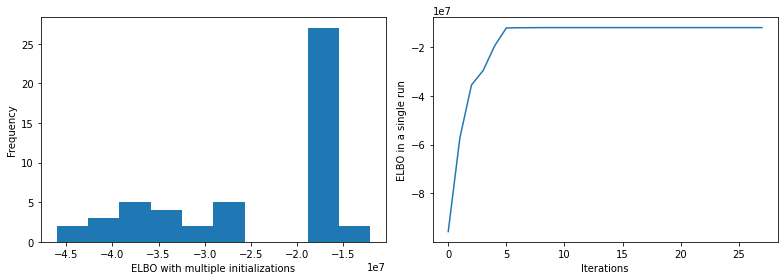

In [12]:
modelCA, elbo = run_vireo(AD, DP, N_DONORS, n_cores=32, plot_qc=True,out_f=join(OUTDIR, "donors"))
try:
    doublet_prob = modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)
except AttributeError: # New version of Vireo 2021
    doublet_prob = vireoSNP.utils.vireo_doublet.predict_doublet(modelCA,AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)

## Extract donors

In [13]:
# cell_clusters = extract_clusters(modelCA, prob_thresh=0.9, doublet_thresh=0.9, doublet_prob=doublet_prob,
#                                  cells_meta=cells_meta, outdir=OUTDIR, out_f="donors")
# cell_clusters

In [14]:
cell_clusters = separate_donors(AD, DP, modelCA, cells_meta, OUTDIR,
                    doublet_prob,
                    prob_thresh = 0.9, doublet_thresh = 0.9, vars_meta=vars_df)
cell_clusters

cell meta
                                   ID              raw ID condition  donor  \
new index                                                                    
1          AAACTGCTCTCGCGGA-1_Control  AAACTGCTCTCGCGGA-1   Control    NaN   
2          AAAGATGCAGCAACGA-1_Control  AAAGATGCAGCAACGA-1   Control    NaN   
3          AAAGGATGTGCTGTGC-1_Control  AAAGGATGTGCTGTGC-1   Control    NaN   
4          AAAGGATTCAAAGTAG-1_Control  AAAGGATTCAAAGTAG-1   Control    NaN   
5          AAATGCCCAGAAAGAG-1_Control  AAATGCCCAGAAAGAG-1   Control    NaN   

           donor_index  
new index               
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
[  0   1   2   3   7   8   9  10  11  12  13  14  15  16  17  19  20  21
  22  23  24  25  26  27  28  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  71 

[  0   1   2   3   5   7   8   9  10  11  12  13  14  15  16  17  19  23
  24  25  26  27  28  30  32  33  34  36  37  38  39  40  41  42  43  46
  47  48  49  51  52  53  54  55  56  57  58  60  62  63  64  65  66  67
  68  69  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  87
  88  89  90  91  92  93  94  95  96  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 115 116 117 118 119 121 122 124 125 126 127
 128 129 130 131 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 198 199 200 201 202 203 205
 206 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 240 242 243 244 245 247
 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265
 267 268 269 270 271 273 274 275 276 277 278 279 28

{0: array([   3,    9,   12,   15,   26,   41,   42,   48,   63,   79,   85,
          92,   93,   94,   95,  101,  103,  104,  115,  116,  120,  126,
         138,  141,  149,  152,  157,  170,  171,  175,  181,  185,  188,
         189,  193,  195,  200,  203,  204,  214,  229,  230,  231,  252,
         262,  267,  268,  272,  280,  283,  286,  288,  296,  297,  304,
         316,  321,  329,  353,  355,  359,  371,  376,  378,  380,  381,
         384,  392,  401,  417,  424,  427,  432,  438,  444,  465,  468,
         470,  486,  491,  495,  497,  500,  505,  509,  513,  518,  519,
         528,  530,  532,  537,  539,  542,  548,  558,  569,  572,  576,
         582,  585,  590,  601,  615,  616,  617,  621,  626,  632,  637,
         647,  654,  657,  658,  667,  675,  677,  709,  710,  714,  718,
         719,  722,  726,  727,  733,  736,  738,  740,  741,  755,  767,
         771,  776,  782,  788,  793,  798,  802,  807,  809,  812,  815,
         818,  820,  853,  861,  86

In [15]:
if to_elbo:
    run_elbo(AD, DP, out_f=join(OUTDIR, "donors_elbo"), 
             n_clone_list=np.arange(N_DONORS-2, N_DONORS+3), 
             n_cores=12, cells_meta=cells_meta, save_clusters=False,)

In [16]:
#modelCA.ID

clustering
cmap Oranges
AF_SNPs shape (501, 5)
clustering
cmap Blues


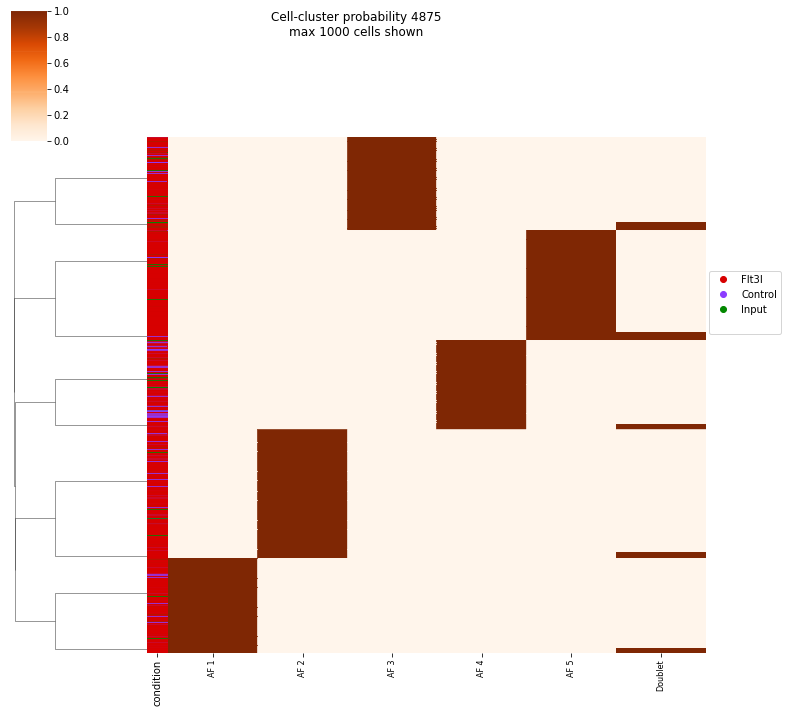

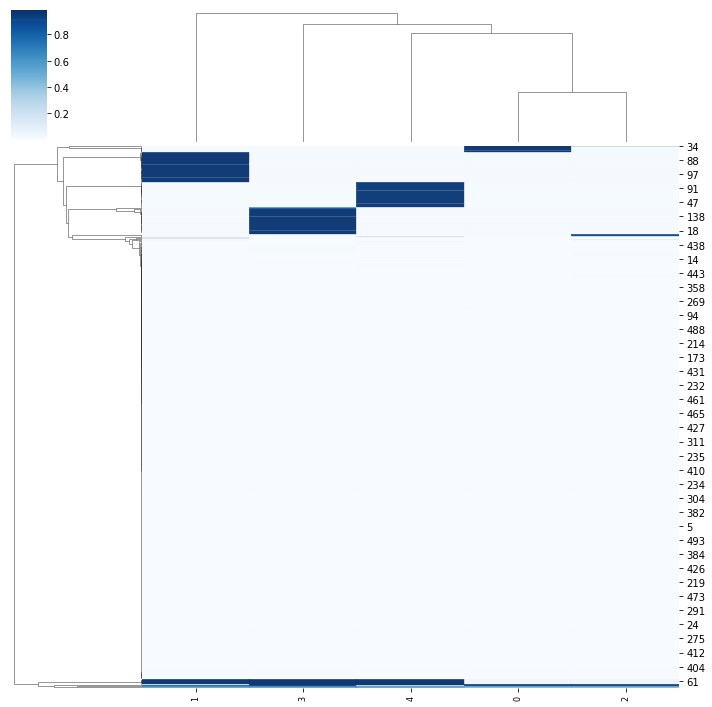

In [17]:
clust_df, AF_SNPs = plot_vireo_out(modelCA, out_f=join(OUTDIR, "multiplex_clusters_all"), labels=cells_meta[['condition']],
                                   to_sqrt=False, doublet_prob=doublet_prob)

Control
             AF 1          AF 2          AF 3          AF 4          AF 5  \
0    2.715171e-07  2.371839e-08  1.866201e-07  1.000000e+00  3.405717e-07   
1    3.618948e-07  2.025060e-07  3.722201e-07  1.000000e+00  3.685317e-07   
2    1.000000e+00  2.432974e-07  4.173987e-07  3.948458e-07  1.020944e-07   
3    2.170017e-07  1.000000e+00  5.003820e-08  4.156468e-07  5.348577e-08   
4    8.035316e-08  2.845406e-07  1.000000e+00  2.787358e-09  3.674766e-07   
..            ...           ...           ...           ...           ...   
483  4.499470e-07  1.000000e+00  3.119482e-07  2.548788e-08  2.151667e-07   
484  2.047672e-07  1.283668e-09  4.578730e-07  1.000000e+00  4.332353e-07   
485  1.000000e+00  4.036069e-07  9.797086e-09  2.004052e-07  2.522144e-07   
486  4.726908e-08  2.166846e-07  1.000000e+00  8.854890e-08  3.184772e-07   
487  7.645862e-08  1.000000e+00  3.997811e-08  3.938318e-07  1.884055e-07   

     Doublet  
0        0.0  
1        0.0  
2        0.0  
3      

<Figure size 432x288 with 0 Axes>

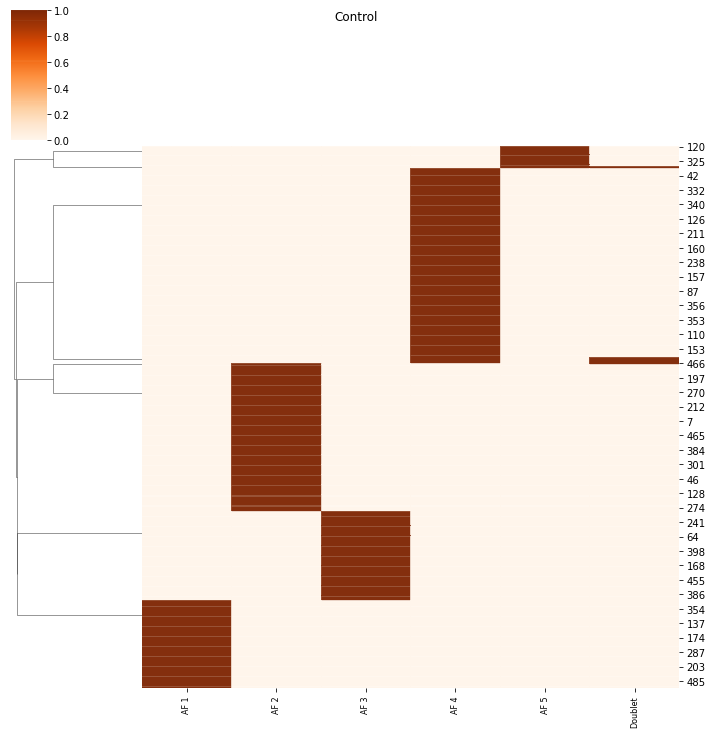

<Figure size 432x288 with 0 Axes>

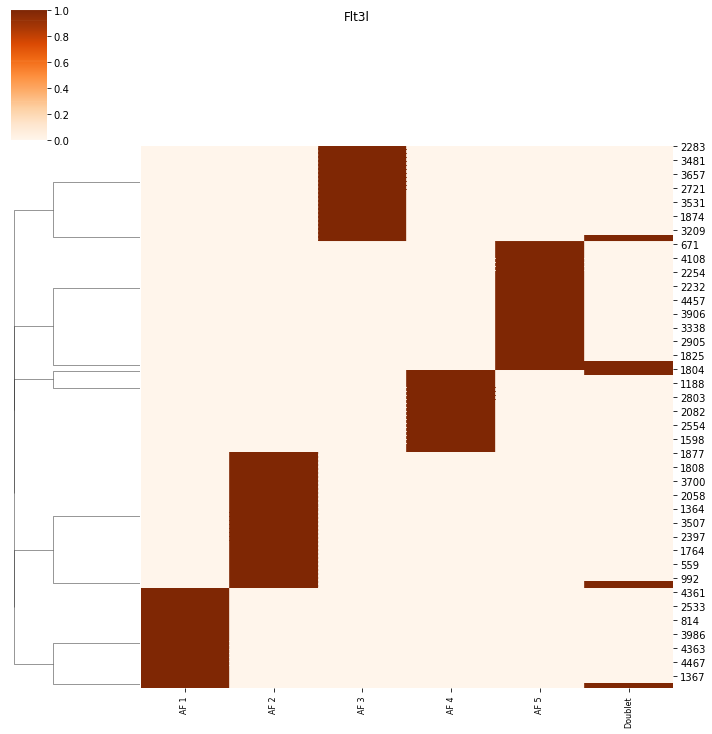

<Figure size 432x288 with 0 Axes>

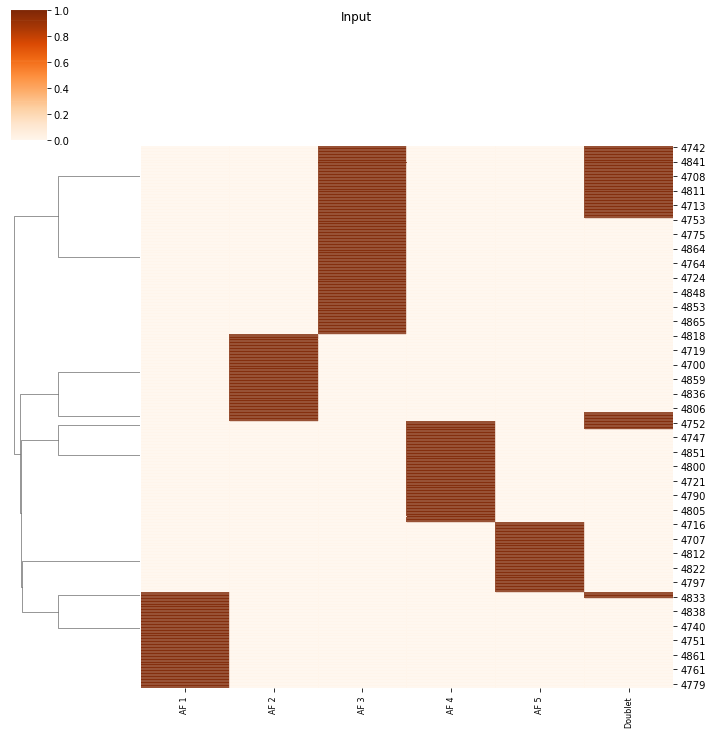

In [18]:
for ind, val in cells_meta.groupby("condition"):
    print(ind)
    print(clust_df.loc[val.index]) #, curr_AF_SNPs
    f = plt.figure()
#     curr_AF_SNPs = AF_SNPs 
#     im = heat_matrix(np.sqrt(curr_AF_SNPs[(curr_AF_SNPs.sum(axis=1)>0.01),:]), cmap="Blues", alpha=0.8,
#             display_value=False, row_sort=True)
    ch.plot_cluster(clust_df.loc[val.index], cmap='Oranges', alpha=0.8,
                to_row_clust=True, to_col_clust=False,
                to_legend=True,
                white_name=None)
    plt.suptitle(ind)
    plt.savefig(join(OUTDIR, f"multiplex_clusters_{ind}"))

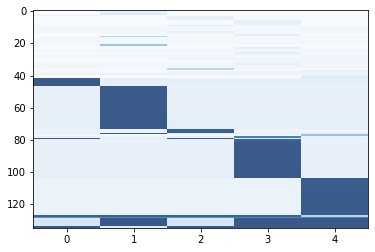

In [19]:
f = plt.figure()
im = heat_matrix(np.sqrt(AF_SNPs[(AF_SNPs.sum(axis=1)>0.01),:]), cmap="Blues", alpha=0.8,
                 display_value=False, row_sort=True)
plt.savefig(join(OUTDIR, "multiplex_AF_SNPs_all_afFilt"))